In [ ]:
import torch
from matplotlib import pyplot as plt

a = torch.rand(1,3,8,8)
N,C,H,W = a.size()
plt.imshow(a[0,0])
plt.colorbar()
plt.show()

In [ ]:
from torch import nn
conv_c = nn.Conv2d(C, 1, 1, bias=False)
conv_h = nn.Conv2d(C, C, (1, W), bias=False, groups=C)
conv_w = nn.Conv2d(C, C, (H, 1), bias=True, groups=C)
act = nn.SELU()
# act = nn.Softmax(dim=2)

x_h = conv_h(a)
x_w = conv_w(a)

print(x_h.shape)
print(x_w.shape)
# print(torch.relu(x_h+x_w).shape)

result = conv_c(act(x_h+x_w)).detach()
# result = torch.softmax(result.view(N,1,-1), dim=2).view(N,1,W,H)
plt.imshow(result[0,0])
plt.colorbar()
plt.show()

In [ ]:
f = torch.mul(result.expand_as(a), a) 
plt.imshow(f[0,1])
plt.colorbar()
plt.show()

# 1st Test

In [ ]:
from torch.nn import functional as F
class CoordAttentionBlock(nn.Module):
    def __init__(self, n_channels: int, img_size: tuple) -> None:
        super(CoordAttentionBlock, self).__init__()
        C = n_channels
        H, W = img_size
        
        self.conv_c = nn.Conv2d(C, 1, 1, bias=False)
        self.conv_h = nn.Conv2d(C, C, (1, W), bias=False)
        self.conv_w = nn.Conv2d(C, C, (H, 1), bias=True)
        # self.conv_h = nn.Conv2d(C, C, (1, W), bias=False, groups=C)
        # self.conv_w = nn.Conv2d(C, C, (H, 1), bias=False, groups=C)
        # self.act = nn.Softmax(1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        N,C,H,W = x.size()
        x_h = self.conv_h(x)
        x_w = self.conv_w(x)

        # c = self.conv_c(torch.relu(x_h+x_w))
        c = self.conv_c(x_h+torch.sigmoid(x_w))
        # c = F.relu(self.conv_c((x_h+x_w)))
        
        a = torch.softmax(c.view(N,1,-1), dim=2).view(N,1,W,H)
        f = torch.mul(a.expand_as(x), x)
        output = f.view(N,C,-1).sum(dim=2)

        return c, output

In [ ]:
class ConvTestBlock(nn.Module):
    def __init__(self, in_channels, out_channels, img_size: tuple) -> None:
        super(ConvTestBlock, self).__init__()
        self.conv = nn.Sequential(*[
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        ])

        self.coordAttBlock = CoordAttentionBlock(out_channels, img_size)

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x = self.conv(x)
        attention = self.coordAttBlock(x)
        
        return torch.mul(attention.expand_as(x), x)

In [ ]:
class Model(nn.Module):
    def __init__(self, ) -> None:
        super(Model, self).__init__()
        self.l1 = nn.Sequential(*[
            nn.Conv2d(3, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ])
        self.l2 = nn.Sequential(*[
            nn.Conv2d(16, 24, 3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.Conv2d(24, 24, 3, padding=1),
            nn.BatchNorm2d(24),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ])
        self.l3 = nn.Sequential(*[
            nn.Conv2d(24, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ])

        self.classifier = nn.Sequential(*[
            nn.Linear(16+24+32,32),
            nn.ReLU(),
            nn.Linear(32,10)
        ])

        img_size = 32
        self.coordAttBlock_l1 = CoordAttentionBlock(16, (int(img_size/2**1), int(img_size/2**1)) )
        self.coordAttBlock_l2 = CoordAttentionBlock(24, (int(img_size/2**2), int(img_size/2**2)) )
        self.coordAttBlock_l3 = CoordAttentionBlock(32, (int(img_size/2**3), int(img_size/2**3)) )

    def forward(self, x:torch.Tensor) -> torch.Tensor:
        x_l1 = self.l1(x)
        x_l2 = self.l2(x_l1)
        x_l3 = self.l3(x_l2)

        c1, g1 = self.coordAttBlock_l1(x_l1)
        c2, g2 = self.coordAttBlock_l2(x_l2)
        c3, g3 = self.coordAttBlock_l3(x_l3)

        g = torch.cat((g1,g2,g3), dim=1)
        y_hat = self.classifier(g)

        return (y_hat, c1, c2, c3)

## Dataset

In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST, CIFAR10
from torchvision.transforms import Compose, ToTensor

transform = Compose([ToTensor()])
# dataset = MNIST('dataset/', train=True, transform=transform, download=True)
train_dataset = CIFAR10('dataset/', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

test_dataset = CIFAR10('dataset/', train=False, transform=transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

img_size = 32

In [ ]:
# linear_input = int((img_size/4 * img_size/4) * 64)
# model = nn.Sequential(*[
#     nn.Conv2d(3,32,3,padding=1),
#     nn.BatchNorm2d(32),
#     nn.ReLU(),
#     nn.MaxPool2d(2),
#     ConvTestBlock(32, 64, (int(img_size/2), int(img_size/2))),
#     nn.MaxPool2d(2),
#     nn.Flatten(1),
#     nn.Linear(linear_input, 32),
#     nn.ReLU(),
#     nn.Linear(32, 10)
# ])

model = Model()

In [ ]:
from tqdm import tqdm
import numpy as np

n_epoch = 10
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

epoch_iterator = tqdm(
        range(n_epoch),
        leave=True,
        unit="epoch",
        postfix={"tls": "%.4f" % 1},
    )

for epoch in epoch_iterator:
    for idx, (input, target) in enumerate(train_loader):
        input = input.to(device)
        target = target.to(device)

        out, c1, c2, c3 = model(input)
        loss = criterion(out, target)

        if idx % 250 == 0:
            epoch_iterator.set_postfix(tls="%.4f" % np.mean(loss.detach().item()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

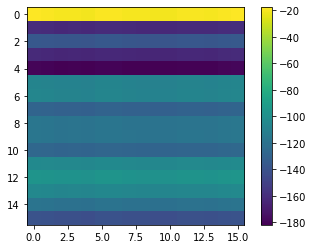

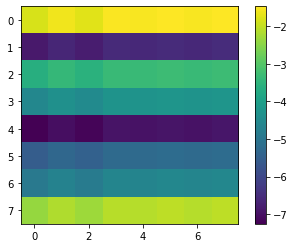

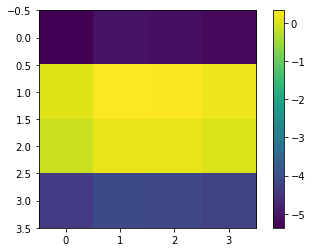

In [129]:
plt.imshow(c1[0,0].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(c2[0,0].detach().cpu())
plt.colorbar()
plt.show()
plt.imshow(c3[0,0].detach().cpu())
plt.colorbar()
plt.show()

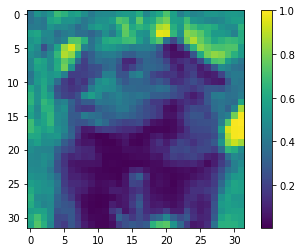

In [134]:
plt.imshow(input[0,0].detach().cpu())
plt.colorbar()
plt.show()

In [130]:
out, _,_,_ = model(input)
torch.argmax(out, dim=1)

tensor([2, 6, 5, 6, 2, 9, 8, 1, 5, 6, 6, 6, 9, 2, 7, 4, 7, 8, 9, 2, 7, 1, 3, 9,
        7, 0, 8, 0, 3, 1, 9, 2, 5, 2, 4, 6, 9, 9, 3, 7, 3, 4, 8, 7, 8, 5, 7, 0,
        7, 4, 3, 4, 3, 1, 4, 3, 2, 0, 7, 9, 0, 0, 5, 3, 0, 6, 4, 8, 4, 5, 7, 0,
        9, 8, 3, 0, 2, 1, 2, 0, 0, 4, 4, 5, 2, 8, 6, 9, 3, 9, 5, 4, 5, 4, 3, 9,
        4, 8, 7, 5, 3, 8, 3, 5, 3, 8, 0, 0, 0, 8, 4, 1, 4, 0, 7, 1, 9, 1, 1, 3,
        4, 4, 0, 8, 4, 0, 6, 5], device='cuda:0')

In [131]:
target

tensor([5, 6, 5, 6, 2, 9, 8, 1, 5, 6, 6, 6, 9, 2, 7, 7, 7, 8, 9, 2, 7, 1, 3, 9,
        7, 0, 8, 1, 3, 1, 9, 2, 5, 2, 4, 6, 9, 9, 5, 7, 3, 4, 8, 7, 8, 6, 7, 2,
        7, 4, 4, 3, 3, 1, 4, 3, 2, 8, 7, 9, 2, 2, 5, 2, 1, 6, 2, 8, 4, 5, 7, 2,
        9, 8, 8, 0, 0, 1, 2, 4, 0, 7, 3, 2, 2, 8, 6, 9, 3, 9, 5, 4, 5, 4, 3, 9,
        7, 8, 7, 5, 3, 8, 3, 5, 3, 1, 0, 0, 2, 8, 4, 1, 7, 0, 7, 1, 9, 1, 1, 5,
        4, 4, 8, 8, 5, 0, 6, 5], device='cuda:0')

In [132]:
(torch.argmax(out, dim=1) == target).sum()

tensor(100, device='cuda:0')

In [133]:
len(target)

128